In [88]:
import pandas as pd
import numpy as np
import random
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from transformers import AutoModel, AutoTokenizer
import os
from tqdm import tqdm

In [89]:
!pip install -U datasets


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\esonicl\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [90]:
# veri seti
dataset = load_dataset("ytu-ce-cosmos/gsm8k_tr")

# eğitim setini al
train_data = dataset['train']

In [91]:
# random 1000 soru-cevap
total_samples = len(train_data)
random_indices = random.sample(range(total_samples), min(1000, total_samples))

# örnekleri ayıkla
selected_questions = [train_data[i]['question'] for i in random_indices]
selected_answers = [train_data[i]['answer'] for i in random_indices]

In [92]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [93]:
# soru-cevapları vektöre dönüştür
question_embeddings = model.encode(selected_questions)
answer_embeddings = model.encode(selected_answers)

In [94]:
# df'e kaydet
data = {'question': selected_questions, 'answer': selected_answers}
df = pd.DataFrame(data)

In [95]:
# soru-cevap çiftlerinin gerçek indeksleri
true_question_to_answer = {i: i for i in range(len(selected_questions))}
true_answer_to_question = {i: i for i in range(len(selected_answers))}

In [96]:
# her soru için en benzer 5 cevap
def find_top_k_similar(embeddings, query_embedding, k=5, exclude_index=None):
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    if exclude_index is not None:
        similarities[exclude_index] = -1  # kendisini hariç tutmak için
    top_indices = np.argsort(similarities)[::-1][:k]
    top_scores = [similarities[i] for i in top_indices]
    return list(zip(top_indices, top_scores))

In [97]:
# sonuçları liste haline getirme
question_to_answer_results = []
answer_to_question_results = []

In [98]:
# her soru için en benzer 5 cevap
for i, question_emb in enumerate(question_embeddings):
    top_answers = find_top_k_similar(answer_embeddings, question_emb, k=5, exclude_index=None)
    is_top1_correct = top_answers[0][0] == true_question_to_answer[i]
    is_top5_correct = true_question_to_answer[i] in [idx for idx, _ in top_answers]
    question_to_answer_results.append((is_top1_correct, is_top5_correct))

In [99]:
# her cevap için en benzer 5 soru
for i, answer_emb in enumerate(answer_embeddings):
    top_questions = find_top_k_similar(question_embeddings, answer_emb, k=5, exclude_index=None)
    is_top1_correct = top_questions[0][0] == true_answer_to_question[i]
    is_top5_correct = true_answer_to_question[i] in [idx for idx, _ in top_questions]
    answer_to_question_results.append((is_top1_correct, is_top5_correct))

In [100]:
# başarı oranları
q_to_a_top1_accuracy = sum([x[0] for x in question_to_answer_results]) / len(question_to_answer_results)
q_to_a_top5_accuracy = sum([x[1] for x in question_to_answer_results]) / len(question_to_answer_results)

a_to_q_top1_accuracy = sum([x[0] for x in answer_to_question_results]) / len(answer_to_question_results)
a_to_q_top5_accuracy = sum([x[1] for x in answer_to_question_results]) / len(answer_to_question_results)

In [101]:
# sonuçlar
print("Sorular için cevap eşleştirme sonuçları:")
print(f"Top-1 başarı oranı: {q_to_a_top1_accuracy:.4f}")
print(f"Top-5 başarı oranı: {q_to_a_top5_accuracy:.4f}")

print("\nCevaplar için soru eşleştirme sonuçları:")
print(f"Top-1 başarı oranı: {a_to_q_top1_accuracy:.4f}")
print(f"Top-5 başarı oranı: {a_to_q_top5_accuracy:.4f}")

Sorular için cevap eşleştirme sonuçları:
Top-1 başarı oranı: 0.8910
Top-5 başarı oranı: 0.9360

Cevaplar için soru eşleştirme sonuçları:
Top-1 başarı oranı: 0.9340
Top-5 başarı oranı: 0.9780


In [102]:
# örnek eşleştirmeler
def display_examples(df, query_type="question", top_k=5, num_examples=3):
    print(f"\n{num_examples} adet örnek {query_type} ve en benzer {top_k} eşleştirme:")
    
    for i in random.sample(range(len(df)), num_examples):
        print(f"\nÖrnek {query_type.capitalize()} {i}: {df[query_type][i]}")
        
        if query_type == "question":
            target_type = "answer"
            embeddings = answer_embeddings
            query_emb = question_embeddings[i]
        else:
            target_type = "question"
            embeddings = question_embeddings
            query_emb = answer_embeddings[i]
            
        top_matches = find_top_k_similar(embeddings, query_emb, k=top_k)
        
        for rank, (match_idx, score) in enumerate(top_matches):
            print(f"  Benzerlik #{rank+1} ({score:.4f}): {df[target_type][match_idx]}")
            if match_idx == i:
                print("  *** Bu doğru eşleştirme ***")

In [103]:
display_examples(df, query_type="question", top_k=5, num_examples=3)
display_examples(df, query_type="answer", top_k=5, num_examples=3)


3 adet örnek question ve en benzer 5 eşleştirme:

Örnek Question 957: John, mavi kravatların iki katı kadar kırmızı kravat satın alır.  Kırmızı kravatlar mavi kravatlardan %50 daha pahalı.  Her biri 40 dolar olan mavi kravatlara 200 dolar harcamıştır. Kravatlara ne kadar harcadı?
  Benzerlik #1 (0.9457): John, 40 dolarlık mavi kravatlardan 200 dolar harcadığına göre, 5 mavi kravat satın almıştır (200 / 40 = 5).

Mavi kravatların iki katı kadar kırmızı kravat aldıysa, 2 * 5 = 10 kırmızı kravat almıştır.

Kırmızı kravatlar mavi kravatlardan %50 daha pahalı olduğundan:
%50 daha pahalı demek 1.5 kat daha pahalı demektir. Bu durumda kırmızı kravatların birim fiyatı 40 * 1.5 = 60 dolardır.

John 10 kırmızı kravat aldığına göre: 10 * 60 = 600 dolar harcamıştır.

Toplam harcaması: 200 + 600 = 800 dolar.

John toplamda 800 dolar harcamıştır.
  *** Bu doğru eşleştirme ***
  Benzerlik #2 (0.6346): Kenneth, bir oz kumaş için 40 dolar ödedi ve 700 oz kumaş aldı. Bu durumda Kenneth, toplamda 700 oz

In [104]:
train_data = dataset['train']
total_samples = len(train_data)
random_indices = random.sample(range(total_samples), min(1000, total_samples))

# örnekleri ayıklama
selected_questions = [train_data[i]['question'] for i in random_indices]
selected_answers = [train_data[i]['answer'] for i in random_indices]

In [105]:
# MTEB liderlik tablosundaki multilingual, 1 milyar parametreden küçük 5 model + turkish-colbert
models = [
    "ibm-granite/granite-embedding-107m-multilingual",   # çok dilli, 107M parametre
    "Alibaba-NLP/gte-multilingual-base",   # çok dilli, 108M parametre
    "ytu-ce-cosmos/turkish-colbert" ,        # Türkçe model
    "intfloat/multilingual-e5-small",       # çok dilli, 118M parametre
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",  # çok dilli, 118M parametre
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",  # çok dilli, 278M parametre
    
]

In [106]:
# sonuçları saklamak için dictionary
results = {}

# t-SNE görselleştirmeleri için gömmeleri saklama
all_embeddings = {}
all_labels = []

In [107]:
# her model için
for model_name in tqdm(models, desc="Models"):
    print(f"\nModel: {model_name}")
    
    # GPU kullanılabilirse
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # model ve tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
    
    # gömme
    def get_embedding(texts, batch_size=8):
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(
                batch, 
                padding=True, 
                truncation=True, 
                max_length=512, 
                return_tensors="pt"
            ).to(device)
            
            with torch.no_grad():
                outputs = model(**inputs)
                # CLS token'ının gömme vektörü
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)
        return np.array(embeddings)
    
    # soru ve cevap gömmeleri
    print("Soruları gömme...")
    question_embeddings = get_embedding(selected_questions)
    print("Cevapları gömme...")
    answer_embeddings = get_embedding(selected_answers)
    
    # t-SNE için tüm gömmeleri birleştir (ilk 100 örnek için)
    combined_embeddings = np.vstack([question_embeddings[:100], answer_embeddings[:100]])
    labels = ["Soru"] * 100 + ["Cevap"] * 100
    
    # tüm temsilleri sakla
    all_embeddings[model_name] = combined_embeddings
    if not all_labels: 
        all_labels = labels
    
    # sonuçlar için listeler
    question_to_answer_results = []
    answer_to_question_results = []
    
    # her soru için en benzer 5 cevap
    for i, q_emb in enumerate(tqdm(question_embeddings, desc="Sorular")):
        similarities = cosine_similarity([q_emb], answer_embeddings)[0]
        top_indices = np.argsort(similarities)[::-1][:5]
        
        # top-1 ve top-5 başarıları (doğru eşleşme aynı indexte ve top5te olmalı)
        is_top1_correct = top_indices[0] == i  
        is_top5_correct = i in top_indices    
        question_to_answer_results.append((is_top1_correct, is_top5_correct))
    
    # her cevap için en benzer 5 soru
    for i, a_emb in enumerate(tqdm(answer_embeddings, desc="Cevaplar")):
        similarities = cosine_similarity([a_emb], question_embeddings)[0]
        top_indices = np.argsort(similarities)[::-1][:5]
        
        # top-1 ve top-5 başarılar
        is_top1_correct = top_indices[0] == i
        is_top5_correct = i in top_indices
        answer_to_question_results.append((is_top1_correct, is_top5_correct))
    
    # başarı oranları
    q_to_a_top1 = sum([x[0] for x in question_to_answer_results]) / len(question_to_answer_results)
    q_to_a_top5 = sum([x[1] for x in question_to_answer_results]) / len(question_to_answer_results)
    
    a_to_q_top1 = sum([x[0] for x in answer_to_question_results]) / len(answer_to_question_results)
    a_to_q_top5 = sum([x[1] for x in answer_to_question_results]) / len(answer_to_question_results)
    
    # sonuçlar
    results[model_name] = {
        "Soru→Cevap Top-1": q_to_a_top1,
        "Soru→Cevap Top-5": q_to_a_top5,
        "Cevap→Soru Top-1": a_to_q_top1,
        "Cevap→Soru Top-5": a_to_q_top5,
        "Ortalama Top-1": (q_to_a_top1 + a_to_q_top1) / 2,
        "Ortalama Top-5": (q_to_a_top5 + a_to_q_top5) / 2
    }


Models:   0%|          | 0/6 [00:00<?, ?it/s]


Model: ibm-granite/granite-embedding-107m-multilingual
Soruları gömme...
Cevapları gömme...


Models:  17%|█▋        | 1/6 [00:47<03:58, 47.79s/it]


Model: Alibaba-NLP/gte-multilingual-base


Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Soruları gömme...
Cevapları gömme...


Models:  33%|███▎      | 2/6 [07:30<17:06, 256.69s/it]


Model: ytu-ce-cosmos/turkish-colbert
Soruları gömme...
Cevapları gömme...


Models:  50%|█████     | 3/6 [12:24<13:40, 273.60s/it]


Model: intfloat/multilingual-e5-small
Soruları gömme...
Cevapları gömme...


Models:  67%|██████▋   | 4/6 [14:06<06:52, 206.06s/it]


Model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Soruları gömme...
Cevapları gömme...


Models:  83%|████████▎ | 5/6 [15:44<02:46, 166.88s/it]


Model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Soruları gömme...
Cevapları gömme...


Models: 100%|██████████| 6/6 [21:04<00:00, 210.81s/it]


In [108]:
# df 
results_df = pd.DataFrame(results).T
print("\nModellerin Başarı Sonuçları:")
print(results_df)

# en iyi model
best_model_top1 = results_df["Ortalama Top-1"].idxmax()
best_model_top5 = results_df["Ortalama Top-5"].idxmax()

print(f"\nEn iyi (top-1) başarıya sahip model: {best_model_top1} ({results_df.loc[best_model_top1, 'Ortalama Top-1']:.4f})")
print(f"En iyi (top-5) başarıya sahip model: {best_model_top5} ({results_df.loc[best_model_top5, 'Ortalama Top-5']:.4f})")


Modellerin Başarı Sonuçları:
                                                    Soru→Cevap Top-1  \
ibm-granite/granite-embedding-107m-multilingual                0.907   
Alibaba-NLP/gte-multilingual-base                              0.905   
ytu-ce-cosmos/turkish-colbert                                  0.690   
intfloat/multilingual-e5-small                                 0.962   
sentence-transformers/paraphrase-multilingual-M...             0.904   
sentence-transformers/paraphrase-multilingual-m...             0.902   

                                                    Soru→Cevap Top-5  \
ibm-granite/granite-embedding-107m-multilingual                0.958   
Alibaba-NLP/gte-multilingual-base                              0.938   
ytu-ce-cosmos/turkish-colbert                                  0.803   
intfloat/multilingual-e5-small                                 0.984   
sentence-transformers/paraphrase-multilingual-M...             0.957   
sentence-transformers/paraphrase-


t-SNE hazırlanıyor: ibm-granite/granite-embedding-107m-multilingual

t-SNE hazırlanıyor: Alibaba-NLP/gte-multilingual-base

t-SNE hazırlanıyor: ytu-ce-cosmos/turkish-colbert

t-SNE hazırlanıyor: intfloat/multilingual-e5-small

t-SNE hazırlanıyor: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

t-SNE hazırlanıyor: sentence-transformers/paraphrase-multilingual-mpnet-base-v2


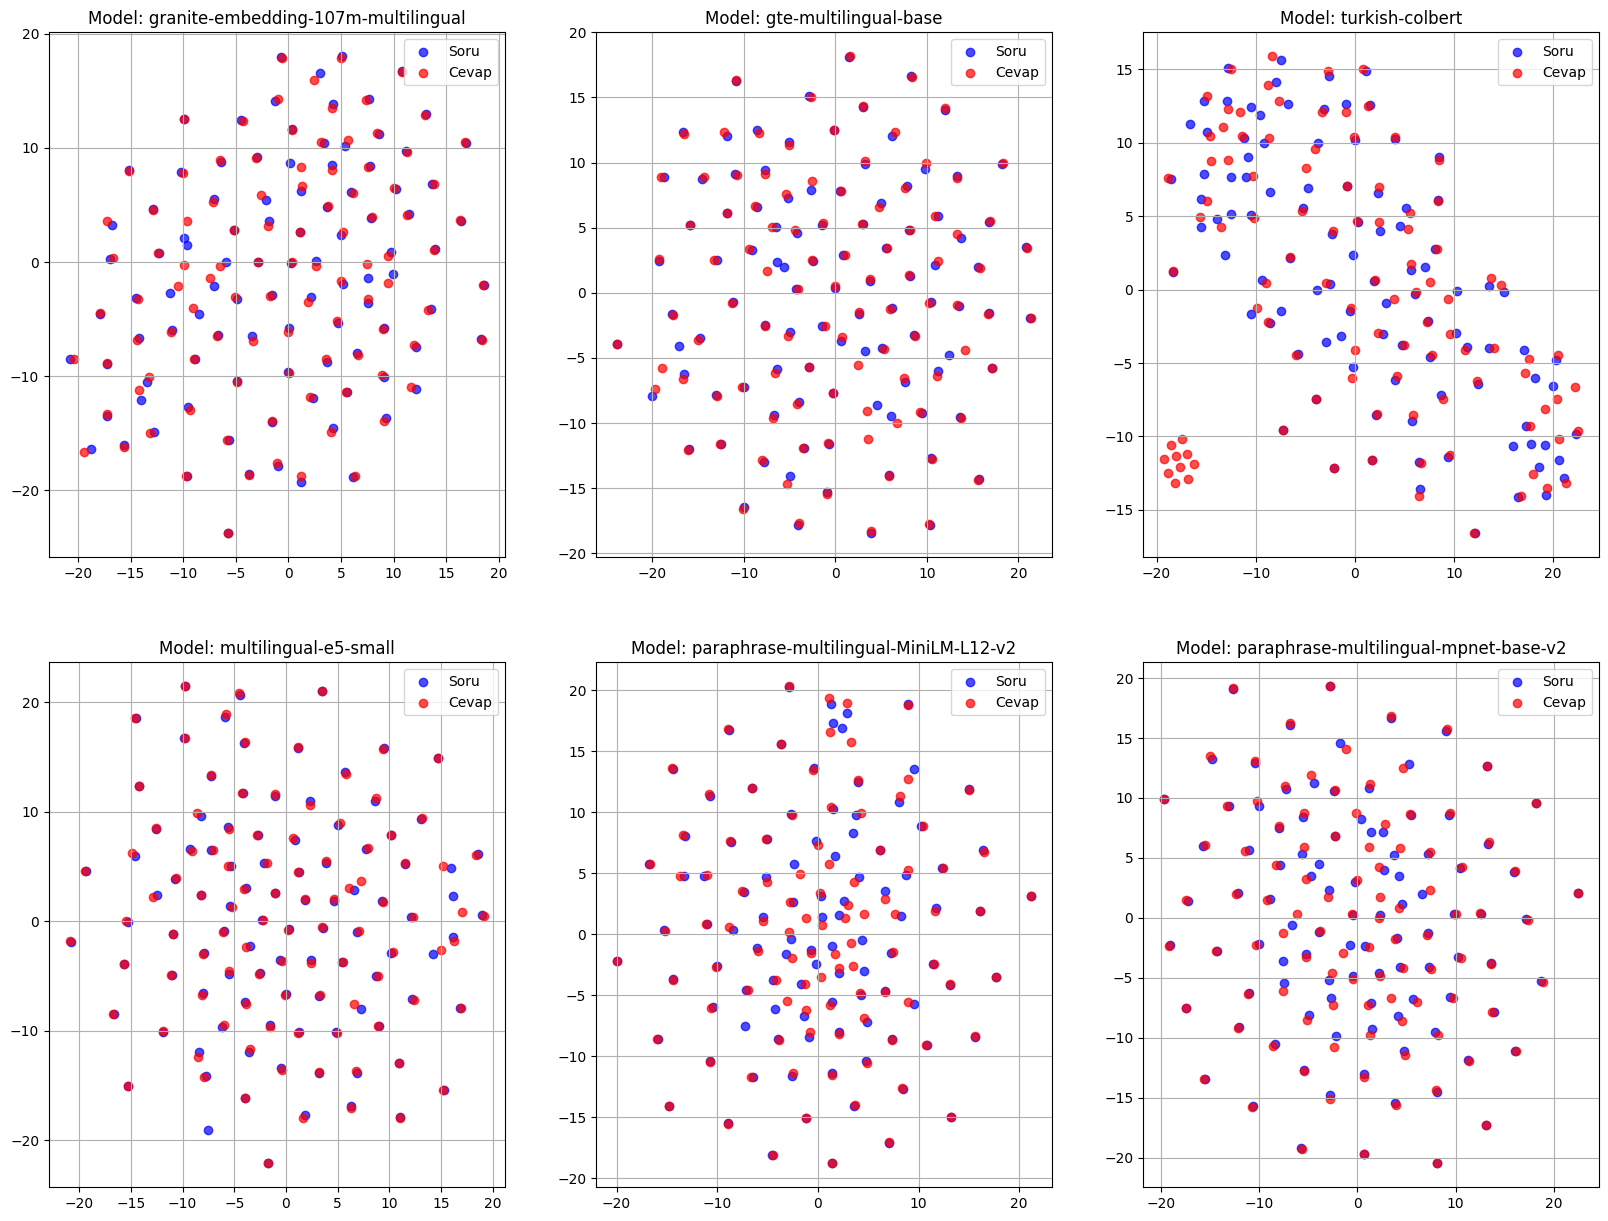

In [109]:
# t-SNE ile görseller 
os.makedirs("tsne_visualizations", exist_ok=True)
plt.figure(figsize=(20, 15))

for i, model_name in enumerate(models):
    print(f"\nt-SNE hazırlanıyor: {model_name}")
    embeddings = all_embeddings[model_name]
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(embeddings)
    
    # subplot oluştur
    plt.subplot(2, 3, i+1)
    
    question_mask = [l == "Soru" for l in all_labels]
    answer_mask = [l == "Cevap" for l in all_labels]
    
    plt.scatter(tsne_results[question_mask, 0], tsne_results[question_mask, 1], 
                c='blue', label='Soru', alpha=0.7)
    plt.scatter(tsne_results[answer_mask, 0], tsne_results[answer_mask, 1], 
                c='red', label='Cevap', alpha=0.7)
    
    plt.title(f"Model: {model_name.split('/')[-1]}")
    plt.legend()
    plt.grid(True)
    
    # model görselleri kaydet
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[question_mask, 0], tsne_results[question_mask, 1], 
                c='blue', label='Soru', alpha=0.7)
    plt.scatter(tsne_results[answer_mask, 0], tsne_results[answer_mask, 1], 
                c='red', label='Cevap', alpha=0.7)
    plt.title(f"t-SNE Görselleştirmesi: {model_name.split('/')[-1]}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"tsne_visualizations/tsne_{model_name.split('/')[-1].replace('-', '_')}.png")
    plt.close()


In [110]:
# ana görsel
plt.tight_layout()
plt.savefig("tsne_visualizations/all_models_tsne.png")
print("\nGörselleştirmeler 'tsne_visualizations' klasörüne kaydedildi.")


Görselleştirmeler 'tsne_visualizations' klasörüne kaydedildi.


<Figure size 640x480 with 0 Axes>

In [111]:
# csv kaydet
results_df.to_csv("model_performance_results.csv")
print("Sonuçlar 'model_performance_results.csv' dosyasına kaydedildi.")

Sonuçlar 'model_performance_results.csv' dosyasına kaydedildi.
